## Импорт библиотек

In [1]:
import pandas as pd
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

#### Дополним данные наименованиями МО и данными о площади областей, плотности населения

In [2]:
# district_name
district_name = pd.read_excel('data/clear/district_name.xlsx')
district_name.head()

,territory_id,oktmo,district_name_short,district_status,district_type,year_from,year_to,region_name,federal_districts_name,federal_districts_name_short
0,1,79-701-000-000,Майкоп,административный центр,город,2018,9999,Республика Адыгея,Южный федеральный округ,ЮФО
1,2,79-703-000-000,Адыгейск,NaN,город,2018,9999,Республика Адыгея,Южный федеральный округ,ЮФО
2,3,79-605-000-000,Гиагинский,NaN,станица,2018,9999,Республика Адыгея,Южный федеральный округ,ЮФО
3,4,79-615-000-000,Кошехабльский,NaN,аул,2018,9999,Республика Адыгея,Южный федеральный округ,ЮФО
4,5,79-618-000-000,Красногвардейский,NaN,село,2018,9999,Республика Адыгея,Южный федеральный округ,ЮФО


In [4]:
# region_square
region_square = pd.read_excel('data/clear/region_square.xlsx')
region_square.head()

,region_name,region_square,region_popularity,region_density,region_unique_districts
0,Белгородская область,27.1,1531.9,56.5,212
1,Брянская область,34.9,1168.8,33.5,236
2,Владимирская область,29.1,1323.7,45.5,127
3,Воронежская область,52.2,2287.7,43.8,478
4,Ивановская область,21.4,976.9,45.6,143


In [7]:
# Выделили таблицу для сопоставления id региона и названием
region_list = region_square['region_name'].reset_index()
region_list.columns = ['region_id', 'region_name']

# Добавили данные по названию федеральных округов
region_list = (region_list
               .merge(district_name[['region_name', 'federal_districts_name', 'federal_districts_name_short']].drop_duplicates(), how='left', on='region_name'))

region_list.head()

,region_id,region_name,federal_districts_name,federal_districts_name_short
0,0,Белгородская область,Центральный федеральный округ,ЦФО
1,1,Брянская область,Центральный федеральный округ,ЦФО
2,2,Владимирская область,Центральный федеральный округ,ЦФО
3,3,Воронежская область,Центральный федеральный округ,ЦФО
4,4,Ивановская область,Центральный федеральный округ,ЦФО


In [8]:
region_list.to_csv('data/to_db/region_list.csv')

In [11]:
# Заменили названия регионов на id региона
region_info = (region_square
               .merge(region_list[['region_id', 'region_name']], how='left', on='region_name')
               [['region_id', 'region_square', 'region_density', 'region_unique_districts']])

In [12]:
# Нормировали значения площади
region_info['region_square'] = region_info['region_square'] * 1000

In [13]:
region_info.to_csv('data/to_db/region_info.csv')

#### Население

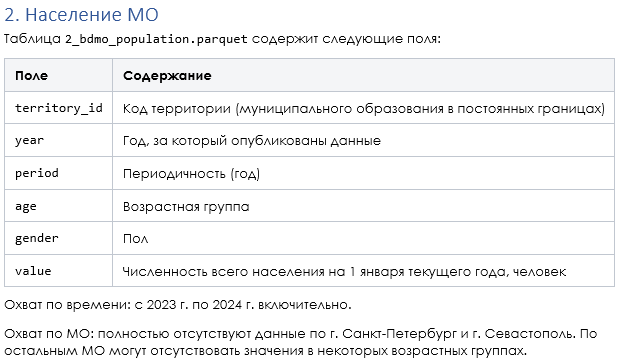

In [28]:
# 2_bdmo_population.parquet
population = pd.read_parquet('data/2_bdmo_population.parquet')
population.head()

,territory_id,year,period,age,gender,value
0,1402,2023,год,0,Женщины,288.0
1,1402,2023,год,0,Мужчины,301.0
2,1402,2023,год,1,Женщины,277.0
3,1402,2023,год,1,Мужчины,316.0
4,1402,2023,год,10,Женщины,414.0


In [29]:
# Привели год к правильному типу
population['year'] = pd.to_datetime(population['year'], format='%Y')

In [30]:
# Посмотрим уникальные значения для возраста
population['age'].unique()

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58',
       '59', '6', '60', '61', '62', '63', '64', '65', '65+', '66', '67',
       '68', '69', '7', '70+', '8', '9', 'Всего', '70', '71', '72', '73',
       '74', '75', '76', '77', '78', '79', '80+'], dtype=object)

In [31]:
# Уберем агрегированное значение и почистим "+" для преобразования к числу
population.drop(columns=['period'], inplace=True)

population = population[~(population['age'].isin(['66', '67',
       '68', '69', 'Всего', '70', '71', '72', '73',
       '74', '75', '76', '77', '78', '79']))]

population['age'] = pd.to_numeric(population['age'].apply(lambda x: x.replace('+', '')))

In [32]:
# Доавим названия регоинов для объединения муниципальных образований в регионы
population = population.merge(district_name[['territory_id', 'region_name']], how='left', on='territory_id')

In [33]:
population.head()

,territory_id,year,age,gender,value,region_name
0,1402,2023-01-01,0,Женщины,288.0,Ленинградская область
1,1402,2023-01-01,0,Мужчины,301.0,Ленинградская область
2,1402,2023-01-01,1,Женщины,277.0,Ленинградская область
3,1402,2023-01-01,1,Мужчины,316.0,Ленинградская область
4,1402,2023-01-01,10,Женщины,414.0,Ленинградская область


In [34]:
# Сгруппируем по регионам и просуммируем население
population = population.pivot_table(index=['region_name', 'year', 'age', 'gender'], values='value', aggfunc=sum).reset_index()

Разделим возраст по категориям

| Тип возраста | Диапазон |
| -- | -- |
| Младше трудоспособного | 0 - 16 |
| Трудоспособного | 16 - 60 (м) / 16 - 55 (ж) |
| Старше трудоспособного | 61+ (м) / 56+ (ж) |

In [35]:
# Выделим категорию трудоспособности по возрасту
m_bins = [-1, 16, 61, 100]
w_bins = [-1, 16, 55, 100]

labels = ['Младше трудоспособного', 'Трудоспособного', 'Старше трудоспособного']

population.loc[population['gender'] == 'Мужчины', 'age_group'] = pd.cut(population.loc[population['gender'] == 'Мужчины', 'age'], bins=m_bins, labels=labels)
population.loc[population['gender'] == 'Женщины', 'age_group'] = pd.cut(population.loc[population['gender'] == 'Женщины', 'age'], bins=w_bins, labels=labels)

In [36]:
# Заменим название региона на id региона
population = (population
              .merge(region_list[['region_id', 'region_name']], how='left', on='region_name')
              [['region_id', 'year', 'age', 'gender', 'age_group', 'value']])

# Отчищаем категории без данных
population.dropna(inplace=True)
# Приводим тип к целочисленному
population['region_id'] = population['region_id'].astype(int)

In [37]:
population.head()

,region_id,year,age,gender,age_group,value
0,67,2023-01-01,0,Женщины,Младше трудоспособного,8767.0
1,67,2023-01-01,0,Мужчины,Младше трудоспособного,9386.0
2,67,2023-01-01,1,Женщины,Младше трудоспособного,9783.0
3,67,2023-01-01,1,Мужчины,Младше трудоспособного,10103.0
4,67,2023-01-01,2,Женщины,Младше трудоспособного,9908.0


In [38]:
population.to_csv('data/to_db/population.csv')

#### Миграция

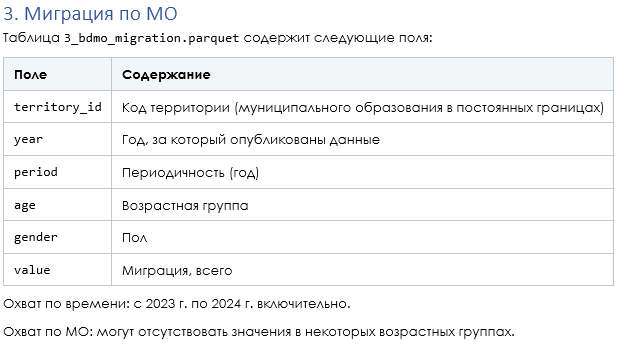

In [40]:
# 3_bdmo_migration.parquet
migration = pd.read_parquet('data/3_bdmo_migration.parquet')
migration.head()

,territory_id,year,period,age,gender,value
0,2335,2023,год,75-79,Женщины,5.0
1,2335,2023,год,75-79,Мужчины,NaN
2,2335,2023,год,55-59,Женщины,-4.0
3,2335,2023,год,55-59,Мужчины,-4.0
4,2335,2023,год,15-19,Женщины,-11.0


In [41]:
# Привели год к правильному типу
migration['year'] = pd.to_datetime(migration['year'], format='%Y')

In [42]:
# Посмотрим уникальные значения для возраста
migration['age'].unique()

array(['75-79', '55-59', '15-19', '90-94', '50-54', '35-39', '95-99',
       '40-44', '0-4', '5-9', '65-69', '80-84', '30-34', '25-29', '3-5',
       '20-24', 'Всего', '10-14', '60-64', '70-74', '45-49', '85-89',
       '100'], dtype=object)

In [43]:
# Убрали период и агреггированные значения, а так же заполним пропуски в покзателе
migration = migration[migration['age'] != 'Всего']
migration.drop(columns=['period'], inplace=True)
migration['value'].fillna(0, inplace=True)

In [44]:
# Сгруппировали данные по регионам
migration = migration.merge(district_name[['territory_id', 'region_name']], how='left', on='territory_id')
migration = migration.pivot_table(index=['region_name', 'year', 'gender', 'age'], values='value', aggfunc='sum').reset_index()

In [46]:
# Посмотрим на распределение миграции по возрастам для случайного региона
import random

region = random.choices(migration['region_name'].unique(), k=1)[0]

data = migration[migration['region_name'] == region]
data['age_start'] = pd.to_numeric(data['age'].apply(lambda x: int(x.split('-')[0])))
data = data.reset_index()

fig = px.histogram(data, x='age_start', y='value', title=f'Динамика миграции по {data["region_name"][0]}')
fig.show()

In [47]:
# Замении назваание региона на id региона
migration = migration.merge(region_list[['region_id', 'region_name']], how='left', on='region_name')[['region_id', 'year', 'age', 'gender', 'value']]

# Отчищаем категории без данных
migration.dropna(inplace=True)
# Приводим тип к целочисленному
migration['region_id'] = migration['region_id'].astype(int)

In [48]:
migration.to_csv('data/to_db/migration.csv')

#### Заработная плата

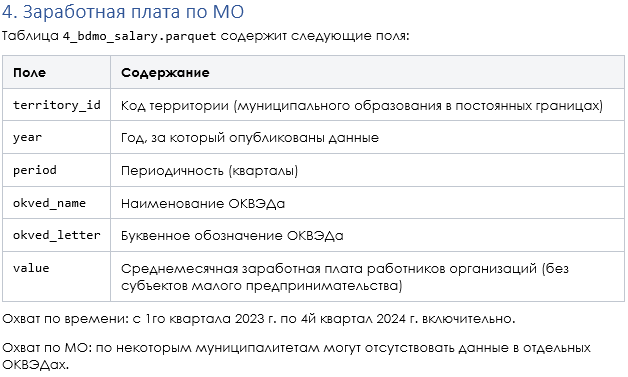

In [50]:
# region_salary.xls
region_salary = pd.read_excel('data/clear/region_salary.xls')
region_salary.head()

,region_name,year,okved_name,value
0,Белгородская область,2022,Все отрасли,47637.8
1,Белгородская область,2022,Сельское хозяйство,51086.0
2,Белгородская область,2022,Добыча полезных ископаемых,74682.4
3,Белгородская область,2022,Обрабатывающие производства,50633.3
4,Белгородская область,2022,Услуги ЖКХ,51502.5


In [51]:
# Привели год к правильному типу
region_salary['year'] = pd.to_datetime(region_salary['year'], format='%Y')

In [52]:
# Заменили названия региона на id региона
region_salary = (region_salary
                 .merge(region_list[['region_id', 'region_name']], how='left', on='region_name'
                        )[['region_id', 'year', 'okved_name', 'value']])

# Очистили категории с пропусками
region_salary.dropna(inplace=True)
# Приводим тип к целочисленному
region_salary['region_id'] = region_salary['region_id'].astype(int)

In [53]:
region_salary.to_csv('data/to_db/region_salary.csv')

#### Автодорожное сообщение

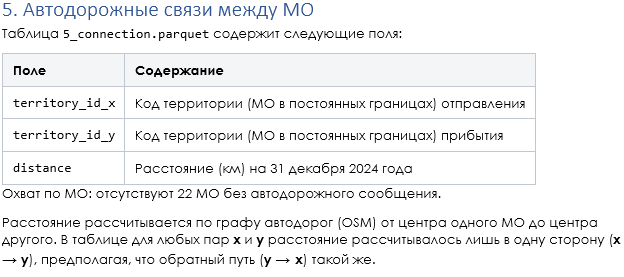

Будем учитывать только дороги связывающие регионы между собой для экономии места

In [65]:
# 5_connection.parquet
connection = pd.read_parquet('data/5_connection.parquet')
connection

,territory_id_x,territory_id_y,distance
0,2,1,100.9
1,3,1,36.1
2,3,2,85.0
3,4,3,44.4
4,4,1,59.9
...,...,...,...
3303731,2313,2286,0.0
3303732,2316,2288,0.0
3303733,2337,2318,0.0
3303734,2334,2320,0.0


In [66]:
# Добавим названия регионов что бы не грузить БД
cols = ['territory_id', 'region_name']

connection = connection \
    .merge(district_name[cols], how='left', left_on='territory_id_x', right_on='territory_id') \
    .rename(columns={'region_name': 'region_name_x'}) \
    .drop(columns=['territory_id'])

connection = connection \
    .merge(district_name[cols], how='left', left_on='territory_id_y', right_on='territory_id') \
    .rename(columns={'region_name': 'region_name_y'}) \
    .drop(columns=['territory_id'])

connection.head()

,territory_id_x,territory_id_y,distance,region_name_x,region_name_y
0,2,1,100.9,Республика Адыгея,Республика Адыгея
1,3,1,36.1,Республика Адыгея,Республика Адыгея
2,3,2,85.0,Республика Адыгея,Республика Адыгея
3,4,3,44.4,Республика Адыгея,Республика Адыгея
4,4,1,59.9,Республика Адыгея,Республика Адыгея


In [67]:
# Выделим дороги только между регионами и посчитаем их количество. Также для полноты данных соединим таблиц с собой же но изменив начальную и конечную точки
region_connection = (connection[connection['region_name_x'] != connection['region_name_y']]
                     .pivot_table(index=['region_name_x', 'region_name_y'], values='distance', aggfunc='count')
                     .reset_index().
                     rename(columns={'distance': 'count'}))

cross_region_connection = region_connection.rename(columns={'region_name_x': 'region_name_y', 'region_name_y': 'region_name_x'})

full_region_connection = pd.concat([region_connection, cross_region_connection]).reset_index(drop=True)

In [68]:
full_region_connection.head()

,region_name_x,region_name_y,count
0,Алтайский край,Кабардино-Балкарская Республика,949
1,Алтайский край,Карачаево-Черкесская Республика,876
2,Алтайский край,Республика Адыгея,657
3,Алтайский край,Республика Алтай,803
4,Алтайский край,Республика Башкортостан,4599


In [69]:
full_region_connection.to_csv('data/to_db/full_region_connection.csv')

#### Уровень безработицы


In [60]:
# region_jobless.xls
region_jobless = pd.read_excel('data/clear/region_jobless.xls')
region_jobless.head()

,region_name,year,value
0,Белгородская область,2022,3.7
1,Белгородская область,2023,3.6
2,Белгородская область,2024,2.9
3,Брянская область,2022,3.2
4,Брянская область,2023,2.6


In [61]:
# Привели год к правильному типу
region_jobless['year'] = pd.to_datetime(region_jobless['year'], format='%Y')

In [62]:
# Заменили названия региона на id региона
region_jobless = (region_jobless
                  .merge(region_list[['region_id', 'region_name']], how='left', on='region_name')
                  [['region_id', 'year', 'value']])

# Очистили категории без данных
region_jobless.dropna(inplace=True)
# Привили тип к целочисленному
region_jobless['region_id'] = region_jobless['region_id'].astype(int)

In [63]:
region_jobless.to_csv('data/to_db/region_jobless.csv')